In [21]:
from tensorflow.keras.models import Model
import tensorflow as tf
from model import lstm_unet
import keras.backend as K
from helpers import f1
import warnings
import numpy as np
from data_loader import DataGenerator
warnings.filterwarnings("ignore")

In [22]:
model = lstm_unet(256, 256, 3, 15)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 15, 256, 256, 3)]    0         []                            
                                                                                                  
 time_distributed_32 (TimeD  (None, 15, 256, 256, 16)     448       ['input_3[0][0]']             
 istributed)                                                                                      
                                                                                                  
 time_distributed_33 (TimeD  (None, 15, 256, 256, 16)     0         ['time_distributed_32[0][0]'] 
 istributed)                                                                                      
                                                                                            

In [23]:
train_gen = DataGenerator(
    image_dir="data_v3_processed/train/images/images",
    mask_dir="data_v3_processed/train/masks/masks",
    batch_size=12,
    time_steps=15,
    img_size=(256,256),
    normalize_images=True,
    normalize_masks=False,
)

In [24]:
val_gen = DataGenerator(
    image_dir="data_v3_processed/val/images/images",
    mask_dir="data_v3_processed/val/masks/masks",
    batch_size=12,
    time_steps=15,
    img_size=(256,256),
    normalize_images=True,
    normalize_masks=False,
)

In [25]:
steps_per_epoch = len(train_gen.samples) // train_gen.batch_size
validation_steps = len(val_gen.samples) // val_gen.batch_size

In [26]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=30,
                    batch_size=12,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/30
18/18 [==============================] - 19s 797ms/step - loss: 0.2122 - f1: 2.0336e-05 - val_loss: 0.1163 - val_f1: 0.0000e+00
Epoch 2/30
18/18 [==============================] - 14s 743ms/step - loss: 0.0778 - f1: 0.0000e+00 - val_loss: 0.0902 - val_f1: 0.0000e+00
Epoch 3/30
18/18 [==============================] - 14s 742ms/step - loss: 0.0630 - f1: 0.0000e+00 - val_loss: 0.0741 - val_f1: 0.0000e+00
Epoch 4/30
18/18 [==============================] - 14s 736ms/step - loss: 0.0567 - f1: 0.0000e+00 - val_loss: 0.0701 - val_f1: 0.0000e+00
Epoch 5/30
18/18 [==============================] - 14s 754ms/step - loss: 0.0549 - f1: 0.0000e+00 - val_loss: 0.0691 - val_f1: 0.0000e+00
Epoch 6/30
18/18 [==============================] - 14s 739ms/step - loss: 0.0537 - f1: 0.0000e+00 - val_loss: 0.0681 - val_f1: 0.0000e+00
Epoch 7/30
18/18 [==============================] - 14s 743ms/step - loss: 0.0524 - f1: 0.0000e+00 - val_loss: 0.0671 - val_f1: 0.0000e+00
Epoch 8/30
18/18 [=========

In [27]:
import cv2
import numpy as np

time_steps = 15
img_size = (256, 256)

# Load and preprocess single image
img = cv2.imread('data_v3_processed/test/images/images/28_05_08_11.png')
img = img.astype(np.float32) / 255.0

# Create a sequence by repeating the image
sequence = np.stack([img] * time_steps, axis=0)  # shape (time_steps, H, W, C)

# Add batch dimension
input_seq = np.expand_dims(sequence, axis=0)  # shape (1, time_steps, H, W, C)

pred = model.predict(input_seq)

1/1 [==============================] - 0s 448ms/step


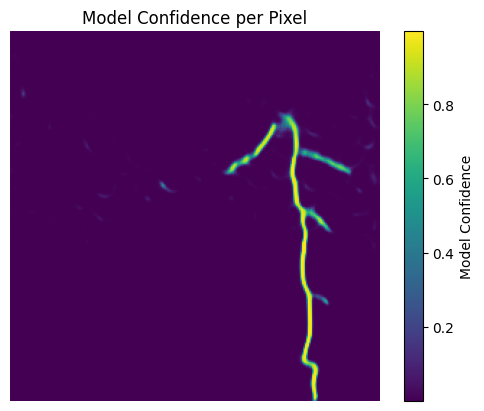

In [28]:
import matplotlib.pyplot as plt

confidence_map = pred[0, :, :, 0]  # Remove batch and channel dims

plt.imshow(confidence_map, cmap='viridis')  # or 'plasma', 'hot', etc.
plt.colorbar(label="Model Confidence")
plt.title("Model Confidence per Pixel")
plt.axis('off')
plt.show()

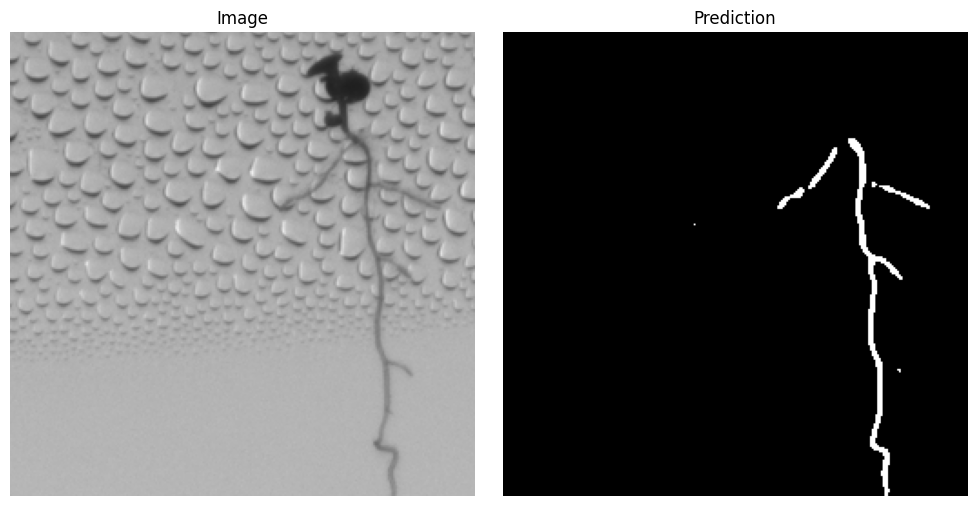

In [29]:
pred = (pred > 0.5).astype(np.uint8)

pred_img = np.squeeze(pred, axis=0)
pred_vis = (pred_img * 255).astype(np.uint8)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # width x height in inches

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image')
plt.axis('off')

# Prediction
plt.subplot(1, 2, 2)
plt.imshow(pred_vis, cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.tight_layout()
plt.show()

In [31]:
model.save("lstm_unet_model.h5")